# Project 2: Neural Networks for Image Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [16]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
#load data chunks and converts to numpy arrays
def load_pose_data():
    pose = np.array(loadmat('./data/pose.mat')['pose'])
    illum = np.array(loadmat('./data/illumination.mat')['illum'])
    return pose, illum

def make_pose_dataset(pose, illum, test_size = .3):
    pose_data = []
    pose_labels = []
    for subject in range(68):
        for img in range(13):
            pose_data.append(pose[:,:,img,subject])
            pose_labels.append(subject)
            
    pose_data = np.array(pose_data)
    pose_labels = np.transpose(np.array(pose_labels))
    
    X_train, X_test, y_train, y_test = train_test_split(pose_data, pose_labels, test_size=test_size, random_state=31, stratify=pose_labels)
    X_train, y_train = list(X_train), list(y_train)
    
    for subject in range(68):
        for img in range(21):
            image = illum[:,img,subject].reshape((40,48))
            image = np.flip(np.rot90(image))
            X_train.append(image)
            y_train.append(subject)
            
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    return X_train, X_test, y_train, y_test

### Networks
##### Below are functions to create the three neural networks architectures that I will be testing. The first is a very simple, shallow sequential NN, the second is a CNN, and the third is a deeper CNN.

In [4]:
#networks
def build_sequential(num_classes):
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn(input_shape):
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_large_cnn(input_shape):
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(input_shape), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [24]:
def cnn(input_shape):
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(input_shape), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


## POSE Dataset
##### I will first test these architectures on the POSE data from project 1.

In [22]:
#load pose data
pose, illum = load_pose_data()
X_train, X_test, y_train, y_test = make_pose_dataset(pose, illum)

#expand dimension to include number channels
X_train = X_train.reshape((X_train.shape[0], 48, 40, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 48, 40, 1)).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
num_pixels = X_train.shape[1] * X_train.shape[2]

#flattened versions of data for sequentail model
X_train_flat = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test_flat = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

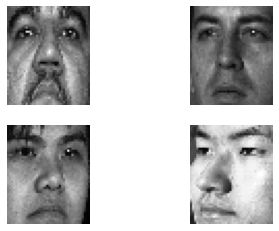

In [9]:
# view pose data
imgs = X_train[:4].reshape((4,48,40))
plt.subplot(221)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(222)
plt.imshow(imgs[1], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(223)
plt.imshow(imgs[2], cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.subplot(224)
plt.imshow(imgs[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.axis('off')
plt.show()

### Simple Sequential Model

In [39]:
# build the model
pose_sequential = build_sequential(num_classes)
# Fit the model
pose_seq_history = pose_sequential.fit(X_train_flat, y_train, validation_data=(X_test_flat, y_test), epochs=100, batch_size=200, verbose=2)
# Final evaluation of the model
scores = pose_sequential.evaluate(X_test_flat, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/100
11/11 - 0s - loss: 6.3703 - accuracy: 0.0288 - val_loss: 6.3297 - val_accuracy: 0.0714
Epoch 2/100
11/11 - 0s - loss: 4.8726 - accuracy: 0.0958 - val_loss: 4.5173 - val_accuracy: 0.0977
Epoch 3/100
11/11 - 0s - loss: 3.7174 - accuracy: 0.2136 - val_loss: 3.8364 - val_accuracy: 0.1053
Epoch 4/100
11/11 - 0s - loss: 3.0448 - accuracy: 0.3543 - val_loss: 3.3693 - val_accuracy: 0.1767
Epoch 5/100
11/11 - 0s - loss: 2.5630 - accuracy: 0.4917 - val_loss: 2.9759 - val_accuracy: 0.2218
Epoch 6/100
11/11 - 0s - loss: 2.1782 - accuracy: 0.6266 - val_loss: 2.9062 - val_accuracy: 0.2632
Epoch 7/100
11/11 - 0s - loss: 1.8719 - accuracy: 0.6804 - val_loss: 2.7821 - val_accuracy: 0.3120
Epoch 8/100
11/11 - 0s - loss: 1.5895 - accuracy: 0.7546 - val_loss: 2.5639 - val_accuracy: 0.3722
Epoch 9/100
11/11 - 0s - loss: 1.3813 - accuracy: 0.7923 - val_loss: 2.2981 - val_accuracy: 0.4398
Epoch 10/100
11/11 - 0s - loss: 1.1682 - accuracy: 0.8407 - val_loss: 2.2765 - val_accuracy: 0.4135
Epoch 11/

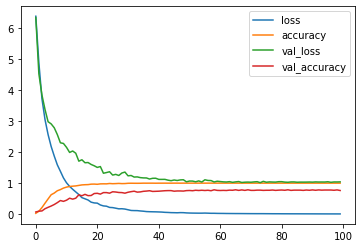

In [40]:
frame = pd.DataFrame(pose_seq_history.history)
frame.plot()

### Convolutional Neural Net

In [7]:
input_shape = (X_train.shape[1],X_train.shape[2],1)

In [8]:
# build the model
pose_cnn = build_cnn(input_shape)
# Fit the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
pose_cnn_history = pose_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, callbacks=es)
# Final evaluation of the model
scores = pose_cnn.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/100
11/11 [==============================] - 1s 75ms/step - loss: 4.2176 - accuracy: 0.0279 - val_loss: 4.1594 - val_accuracy: 0.0451
Epoch 2/100
11/11 [==============================] - 1s 73ms/step - loss: 4.0515 - accuracy: 0.0885 - val_loss: 4.0062 - val_accuracy: 0.0940
Epoch 3/100
11/11 [==============================] - 1s 69ms/step - loss: 3.7649 - accuracy: 0.1667 - val_loss: 3.7442 - val_accuracy: 0.1241
Epoch 4/100
11/11 [==============================] - 1s 71ms/step - loss: 3.3121 - accuracy: 0.3016 - val_loss: 3.3622 - val_accuracy: 0.1917
Epoch 5/100
11/11 [==============================] - 1s 80ms/step - loss: 2.7275 - accuracy: 0.4858 - val_loss: 2.8670 - val_accuracy: 0.2782
Epoch 6/100
11/11 [==============================] - 1s 74ms/step - loss: 2.1422 - accuracy: 0.6173 - val_loss: 2.5794 - val_accuracy: 0.3684
Epoch 7/100
11/11 [==============================] - 1s 80ms/step - loss: 1.6526 - accuracy: 0.7072 - val_loss: 2.1944 - val_accuracy: 0.4173
Epoch 

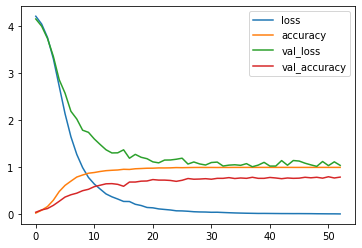

In [9]:
pd.DataFrame(pose_cnn_history.history).plot()

### Large Convolutional Neural Net

In [30]:
# build the model
large_cnn = cnn(input_shape)
# Fit the model
large_cnn_history = large_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=200)
# Final evaluation of the model
scores = large_cnn.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/15
11/11 [==============================] - 1s 103ms/step - loss: 4.2200 - accuracy: 0.0122 - val_loss: 4.2167 - val_accuracy: 0.0150
Epoch 2/15
11/11 [==============================] - 1s 95ms/step - loss: 4.2142 - accuracy: 0.0191 - val_loss: 4.2097 - val_accuracy: 0.0301
Epoch 3/15
11/11 [==============================] - 1s 95ms/step - loss: 4.2021 - accuracy: 0.0171 - val_loss: 4.1874 - val_accuracy: 0.0150
Epoch 4/15
11/11 [==============================] - 1s 93ms/step - loss: 4.1568 - accuracy: 0.0440 - val_loss: 4.1303 - val_accuracy: 0.0338
Epoch 5/15
11/11 [==============================] - 1s 94ms/step - loss: 4.0402 - accuracy: 0.0611 - val_loss: 3.9576 - val_accuracy: 0.0714
Epoch 6/15
11/11 [==============================] - 1s 95ms/step - loss: 3.8013 - accuracy: 0.0743 - val_loss: 3.7223 - val_accuracy: 0.1053
Epoch 7/15
11/11 [==============================] - 1s 95ms/step - loss: 3.4078 - accuracy: 0.1486 - val_loss: 3.4101 - val_accuracy: 0.1504
Epoch 8/15
1

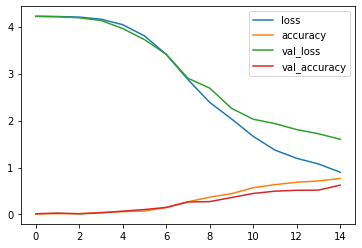

In [31]:
pd.DataFrame(dict(large_cnn_history.history)).plot()

## MNIST

In [56]:
#load mnist data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

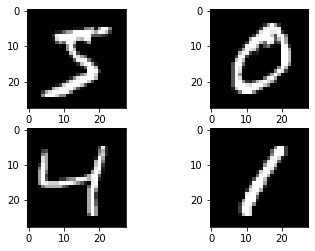

In [57]:
# view mnist data
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

#### Data Preprocessing

In [58]:
#expand dimension to include number channels
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
num_pixels = X_train.shape[1] * X_train.shape[2]

#flattened versions of data for sequentail model
X_train_flat = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test_flat = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

### Simple Sequential Network

In [52]:
# build the model
mnist_sequential = build_sequential(num_classes)
# Fit the model
mnist_sequential.fit(X_train_flat, y_train, validation_data=(X_test_flat, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = mnist_sequential.evaluate(X_test_flat, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
11/11 - 0s - loss: 6.2141 - accuracy: 0.0293 - val_loss: 5.7686 - val_accuracy: 0.0301
Epoch 2/10
11/11 - 0s - loss: 4.5497 - accuracy: 0.1022 - val_loss: 4.0825 - val_accuracy: 0.0902
Epoch 3/10
11/11 - 0s - loss: 3.4987 - accuracy: 0.2199 - val_loss: 3.5931 - val_accuracy: 0.1579
Epoch 4/10
11/11 - 0s - loss: 3.0485 - accuracy: 0.3568 - val_loss: 3.5516 - val_accuracy: 0.0977
Epoch 5/10
11/11 - 0s - loss: 2.6345 - accuracy: 0.4780 - val_loss: 3.1489 - val_accuracy: 0.2556
Epoch 6/10
11/11 - 0s - loss: 2.2452 - accuracy: 0.5968 - val_loss: 2.8484 - val_accuracy: 0.3571
Epoch 7/10
11/11 - 0s - loss: 1.9214 - accuracy: 0.6745 - val_loss: 2.7247 - val_accuracy: 0.3609
Epoch 8/10
11/11 - 0s - loss: 1.6413 - accuracy: 0.7449 - val_loss: 2.5344 - val_accuracy: 0.4060
Epoch 9/10
11/11 - 0s - loss: 1.4040 - accuracy: 0.8021 - val_loss: 2.4427 - val_accuracy: 0.3722
Epoch 10/10
11/11 - 0s - loss: 1.2495 - accuracy: 0.8216 - val_loss: 2.3095 - val_accuracy: 0.4323
Baseline Error: 56.

### Convolutional Neural Net

In [61]:
input_shape = (X_train.shape[1],X_train.shape[2],1)

In [62]:
# build the model
mnist_cnn = build_cnn(input_shape)
# Fit the model
mnist_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=200)
# Final evaluation of the model
scores = mnist_cnn.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/5
300/300 [==============================] - 9s 30ms/step - loss: 0.2419 - accuracy: 0.9292 - val_loss: 0.0821 - val_accuracy: 0.9743
Epoch 2/5
300/300 [==============================] - 9s 30ms/step - loss: 0.0753 - accuracy: 0.9780 - val_loss: 0.0497 - val_accuracy: 0.9840
Epoch 3/5
300/300 [==============================] - 9s 29ms/step - loss: 0.0527 - accuracy: 0.9840 - val_loss: 0.0430 - val_accuracy: 0.9861
Epoch 4/5
300/300 [==============================] - 9s 29ms/step - loss: 0.0412 - accuracy: 0.9873 - val_loss: 0.0359 - val_accuracy: 0.9882
Epoch 5/5
300/300 [==============================] - 9s 30ms/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0334 - val_accuracy: 0.9893
CNN Error: 1.07%


### Large Convolutional Neural Net

In [63]:
# build the model
mnist_large_cnn = build_large_cnn(input_shape)
# Fit the model
mnist_large_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200)
# Final evaluation of the model
scores = mnist_large_cnn.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/2
300/300 [==============================] - 13s 44ms/step - loss: 0.3968 - accuracy: 0.8780 - val_loss: 0.0830 - val_accuracy: 0.9760
Epoch 2/2
300/300 [==============================] - 13s 43ms/step - loss: 0.0981 - accuracy: 0.9700 - val_loss: 0.0491 - val_accuracy: 0.9834
Large CNN Error: 1.66%
